In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from PIL import Image
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.utils import model_to_dot
import gdown

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1bkDVkDJkmOtyYBWOuoqS-P2utkFuaMLI/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1bkDVkDJkmOtyYBWOuoqS-P2utkFuaMLI
From (redirected): https://drive.google.com/uc?id=1bkDVkDJkmOtyYBWOuoqS-P2utkFuaMLI&confirm=t&uuid=bab41139-57b3-4d0d-a24c-7700a3b451d8
To: /content/img_align_celeba.zip
100% 1.41G/1.41G [00:35<00:00, 39.5MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip img_align_celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/197600.jpg  
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  i

In [ ]:
PIC_DIR = '/content/img_align_celeba'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    try:
        pic = Image.open(os.path.join(PIC_DIR, pic_file)).crop(crop_rect)
        pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
        images.append(np.uint8(pic))
    except FileNotFoundError:
        print(f"File not found: {pic_file}. Skipping...")

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-5-6fd30e4d7f5a>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
100%|██████████| 10000/10000 [00:16<00:00, 615.20it/s]


In [ ]:
images = np.array(images) / 255
print(images.shape)

(10000, 128, 128, 3)


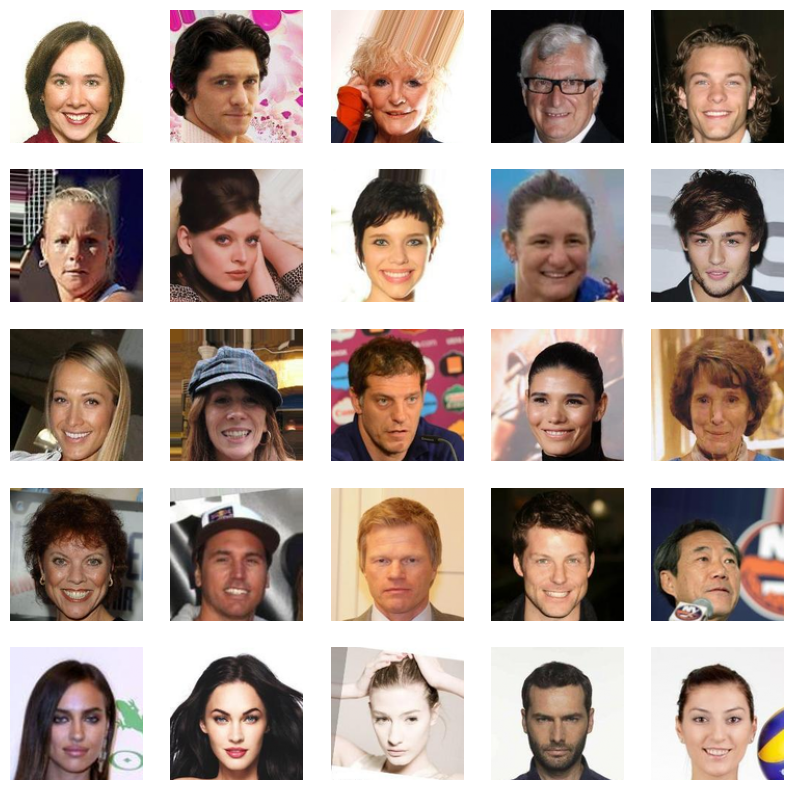

In [ ]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator


In [ ]:

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        learning_rate=0.0001,
        clipvalue=1.0
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [ ]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

In [ ]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [ ]:
optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19165700 (73.11 MB)
Trainable params: 14953987 (57.04 MB)
Non-trainable params: 4211713 (16.07 MB)
_________________________________________________________________


In [ ]:
import time
import numpy as np
import os
from PIL import Image as Img

iters = 100
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            im = Img.fromarray(np.uint8(control_generated[i] * 255))
            im.save(FILE_PATH % (RES_DIR, images_saved))
            images_saved += 1


1/1 [==============================] - 0s 18ms/step
50/100: d_loss: 0.6274,  a_loss: 0.9350.  (3.5 sec)
1/1 [==============================] - 0s 26ms/step
100/100: d_loss: 0.4223,  a_loss: 1.5829.  (3.9 sec)
2/2 [==============================] - 1s 654ms/step


In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(d_losses, color='red', label='Discriminant Losses')
plt.plot(a_losses, label='Adversary Losses')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
images_saved

In [ ]:
import matplotlib.pyplot as plt
import os

# Get the list of image files in RES_DIR
image_files = os.listdir(RES_DIR)

image_files[-1]

In [ ]:
import matplotlib.image as mpimg

def visualize_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
image_path = '/content/res2/generated_1.png'  # Replace with your image file path
visualize_image(image_path)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image

In [ ]:
classifier_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=(224, 224, 3))
])

In [ ]:
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
def is_ai_generated(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict using the classifier
    prediction = classifier.predict(img_array)

    # If the prediction score is above a certain threshold, consider it as AI-generated
    # You might need to adjust this threshold based on your specific use case and data
    threshold = -0.5
    is_generated = prediction[0][0] < threshold

    #print(prediction[0][0])

    return is_generated

In [ ]:
image_path = '/content/res2/generated_71.png'

In [ ]:
result = is_ai_generated(image_path)
if result:
    print("The image is likely AI-generated.")
else:
    print("The image is likely not AI-generated.")

1/1 [==============================] - 0s 76ms/step
The image is likely AI-generated.


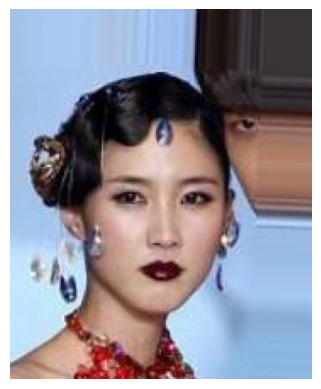

In [ ]:
image_path = '/content/img_align_celeba/041190.jpg'  # Replace with your image file path
visualize_image(image_path)

In [ ]:
result = is_ai_generated(image_path)
if result:
    print("The image is likely AI-generated.")
else:
    print("The image is likely not AI-generated.")

1/1 [==============================] - 0s 75ms/step
The image is likely not AI-generated.


In [ ]:
real = images[:10000 //2]
generated = images[len(images) // 2:]

In [ ]:
real_labels = np.ones(len(real))  # Label 1 for real images
generated_labels = np.zeros(len(generated))  # Label 0 for generated images

In [ ]:
y = np.concatenate([real_labels, generated_labels])

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import hog

In [ ]:
def extract_features(images):
    features = []
    for img in images:
        gray_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
        hog_features = hog(gray_img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
        features.append(hog_features)
    return np.array(features)

In [ ]:
X = extract_features(images)
y = np.concatenate([np.ones(len(real)), np.zeros(len(generated))])

In [ ]:
assert len(X) == len(y), "Number of samples in X and y must be equal"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

In [ ]:
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)